In [1]:
# %load ../../scripts/qc.py
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import argparse
from scipy.stats import linregress
from collections import defaultdict
from pprint import pprint

In [3]:
######### Input ########

## Read in data; use the ID to index individual oligos    
counts = pd.read_csv('./raw/2018.01.08.annotatedCounts.csv', index_col=0)
out_path = './'
print counts.head()

                                                     Virus_Strain  \
id                                                                  
1                                                  CHIKV_KPA15_NS   
100                                                CHIKV_KPA15_NS   
1001                                      DENV2_BR-BID-V3653-2008   
1002                                      DENV2_BR-BID-V3653-2008   
1008.1177.1346  DENV2_BR-BID-V3653-2008.DENV2_BurkinaFaso1983....   

                                 Start_to_End_nt  \
id                                                 
1                                         1to118   
100                                   5941to6058   
1001                                  7381to7498   
1002                                  7441to7558   
1008.1177.1346  7801to7918.7801to7918.7801to7918   

                                       Peptide_sequence  006_10ng.rep1  \
id                                                                       
1  

In [8]:
#########  Initial cleanup & normalization #########
 # We know these animals were previously vaccinated with HIV antigen; drop those oligos
hiv_oligos = counts.loc[counts['Virus_Strain'].str.contains('HIV')]
counts.drop(hiv_oligos.index.values, axis=0, inplace=True)

# For convenience, separate out the metadata, input counts, background counts and metadata.
def proportions(df):
    ''' For each column, divide each element by the sum of the column (column sums to 1)'''
    xsum=df.sum(0)
    df = df.div(xsum, axis='columns')
    return df

input_cols = [ c for c in counts.columns.values if 'input' in c.lower() ]
beads_cols = [ c for c in counts.columns.values if 'beads' in c.lower() ]
metadata_cols = ['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']
sample_cols = [c for c in counts if not any([c in input_cols, c in beads_cols, c in metadata_cols])]

metadata = counts[metadata_cols]
# Standardize each column to sum to 1
values = proportions(counts[[c for c in counts.columns.values if c not in metadata_cols]])
input_ctrls = values[input_cols]
beads_ctrls = values[beads_cols]

In [9]:
######  Find technical and biological replicates, plot direct comparisons #########
technical_replicates = defaultdict(list)
for serum in sample_cols:
    technical_replicates[serum.rsplit('_', 1)[0]].append(serum) # Find replicates
technical_replicates = dict(technical_replicates) # Turn off defaultdict behavior

# pprint(technical_replicates)

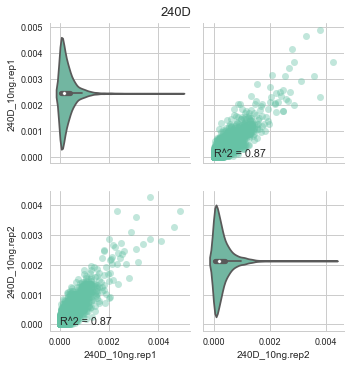

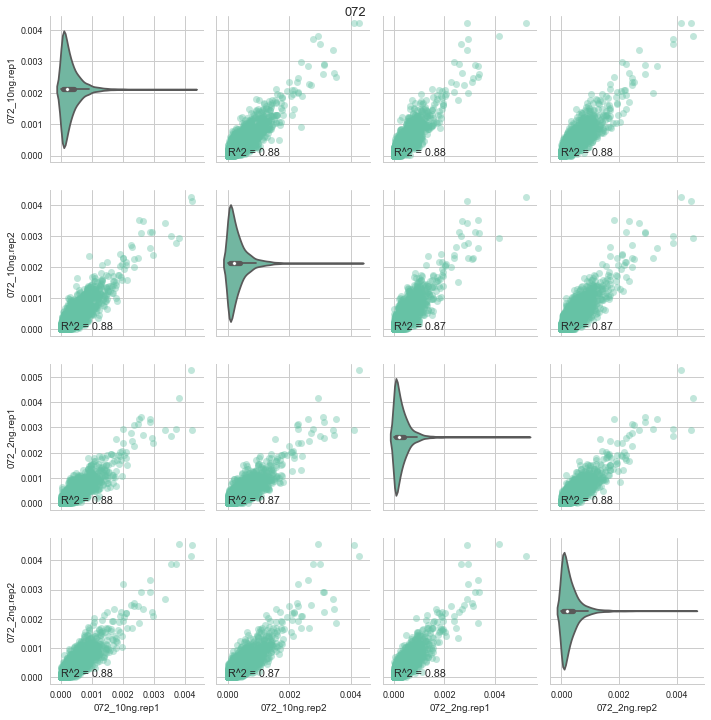

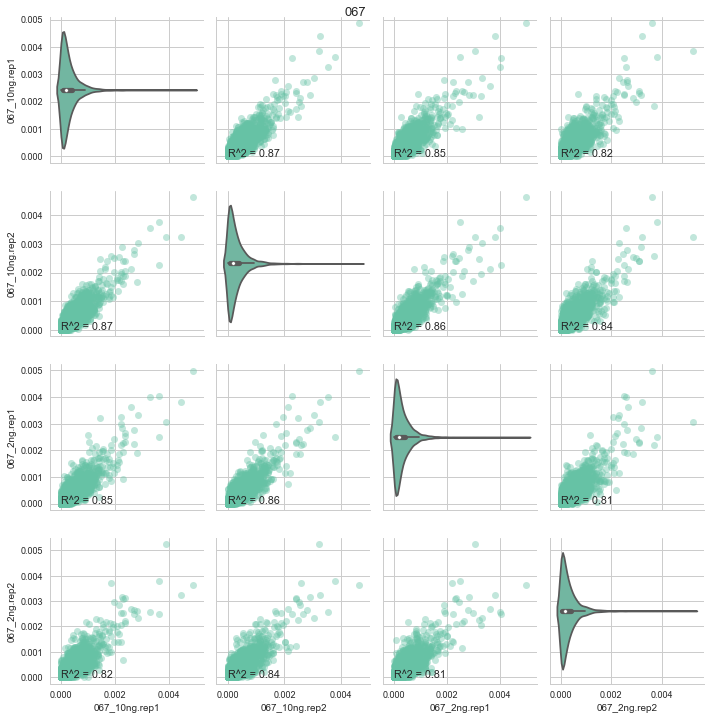

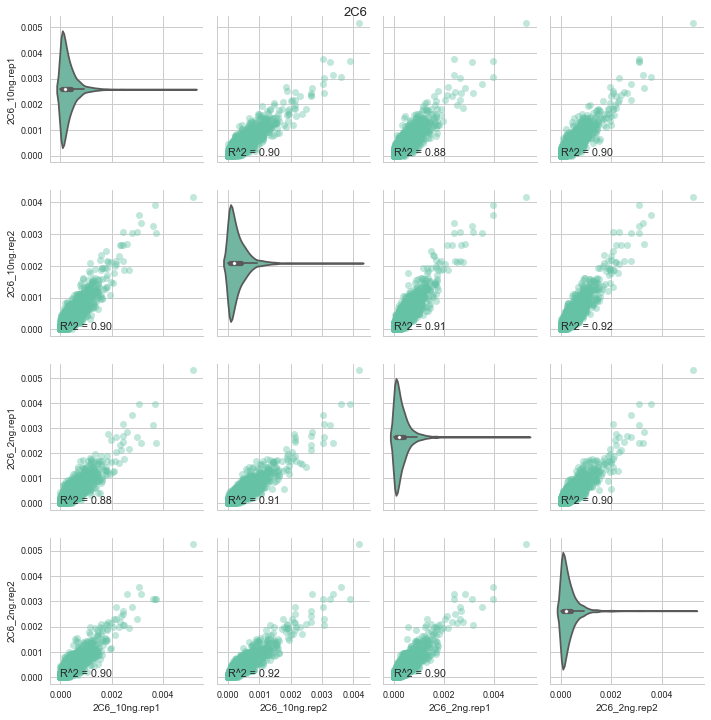

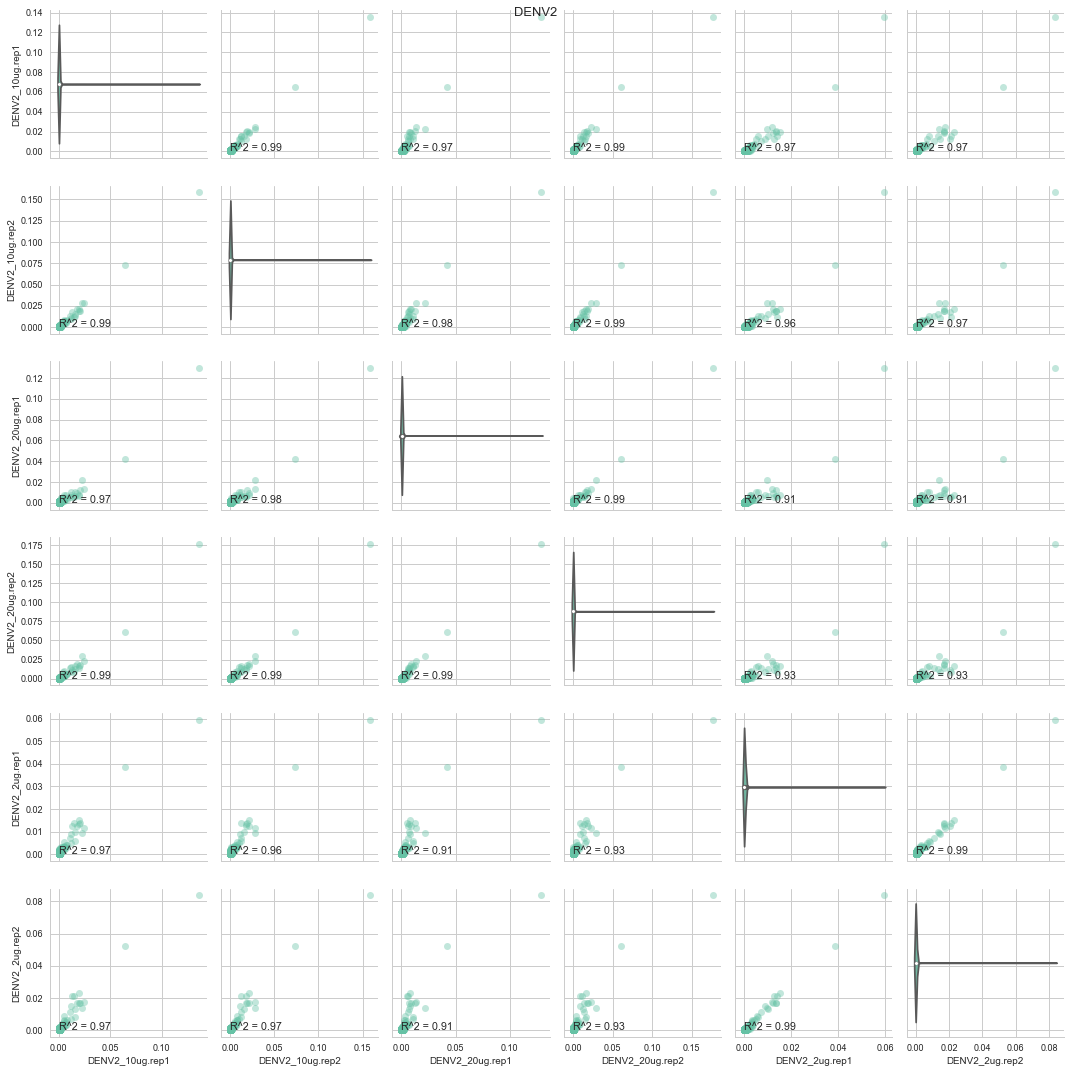

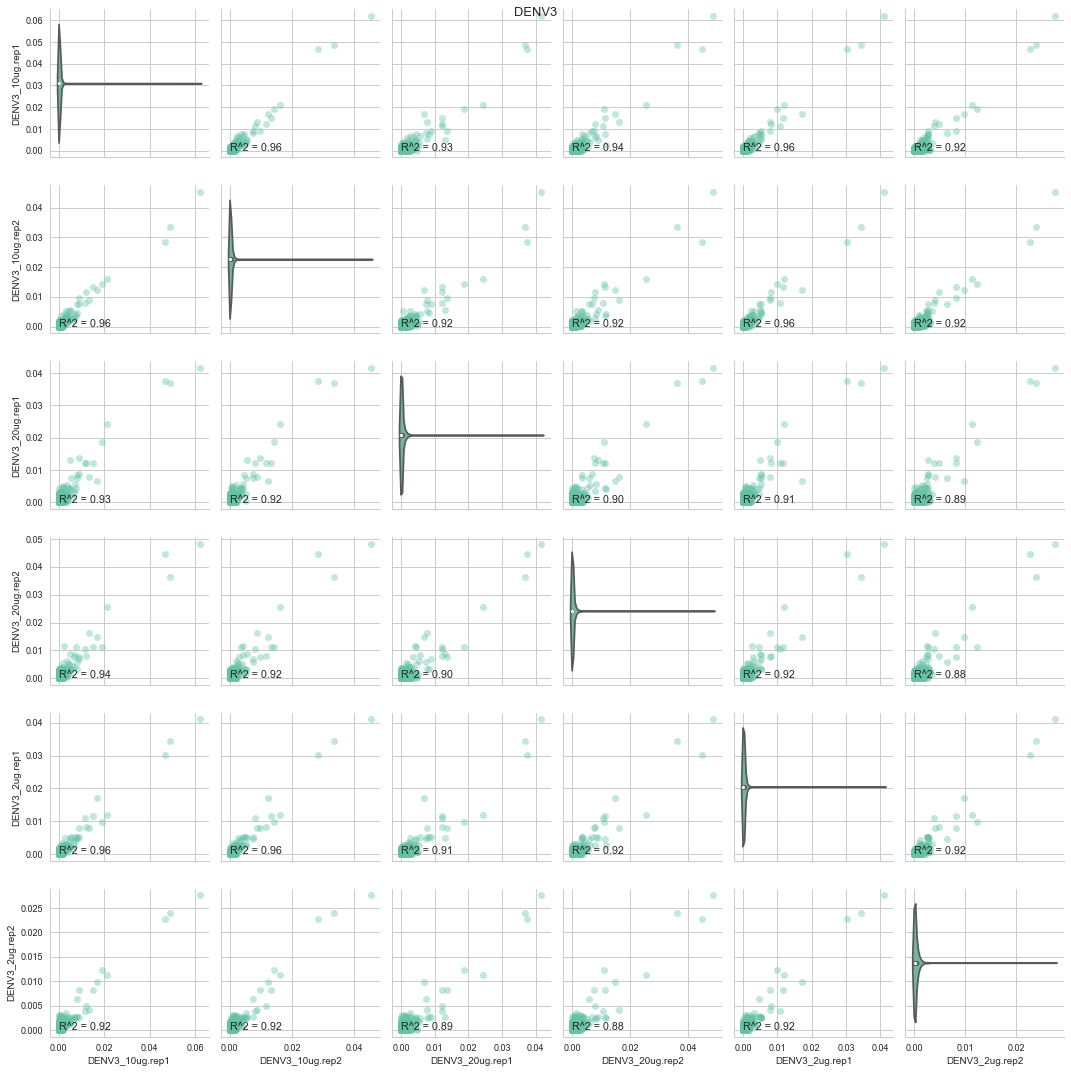

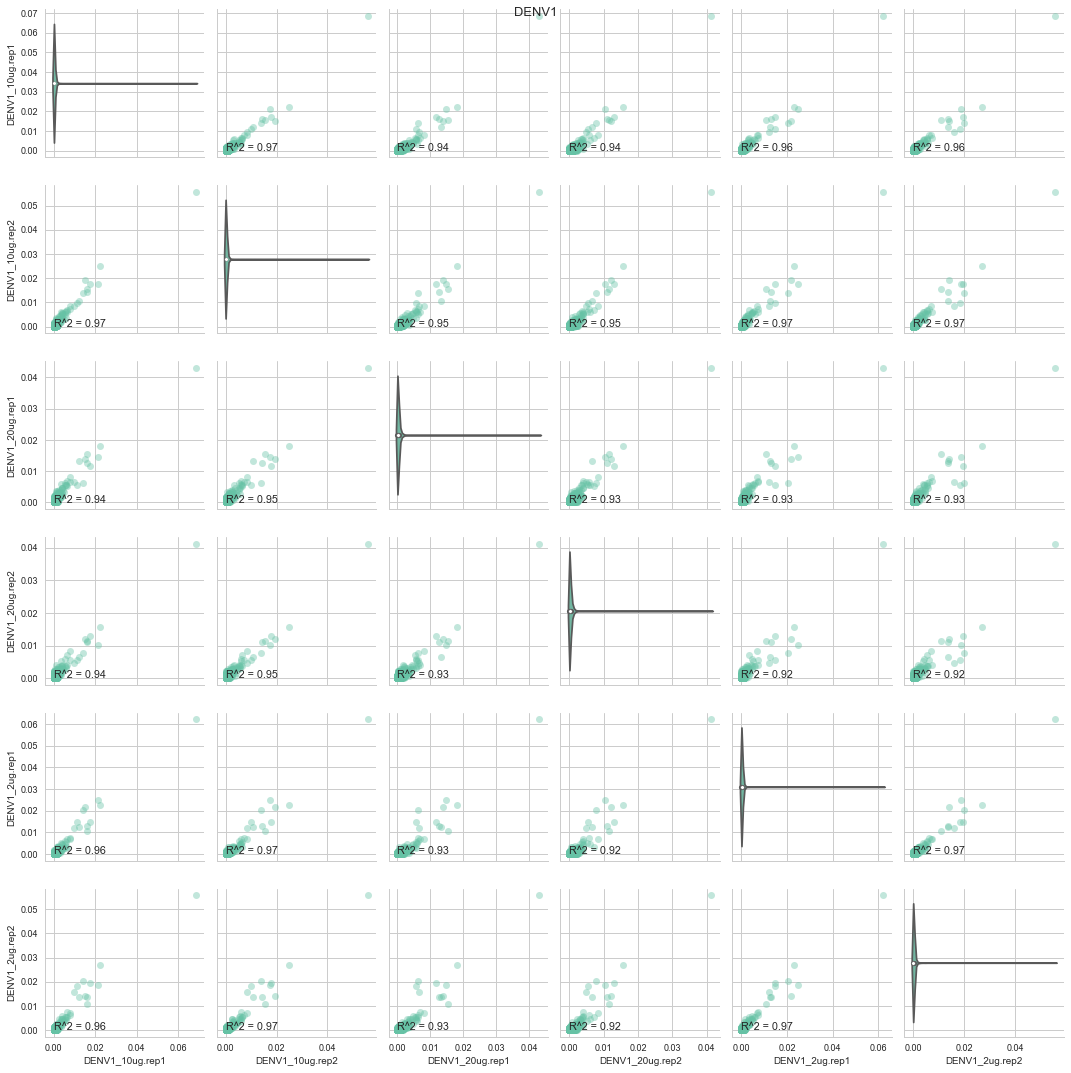

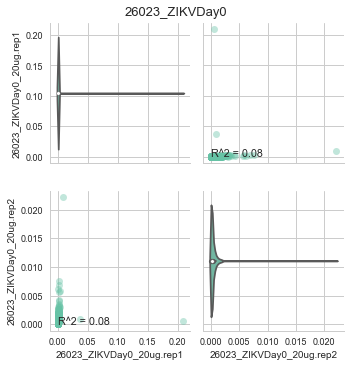

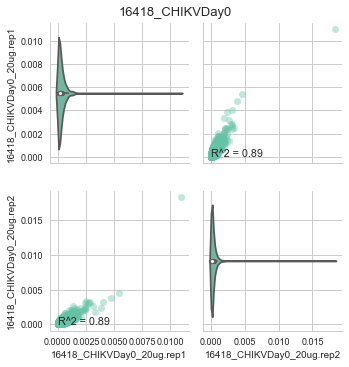

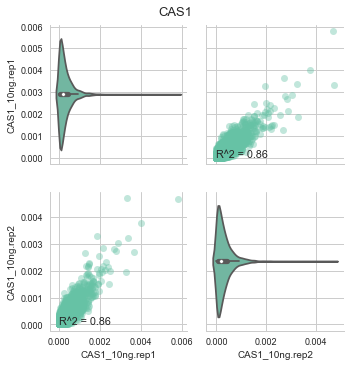

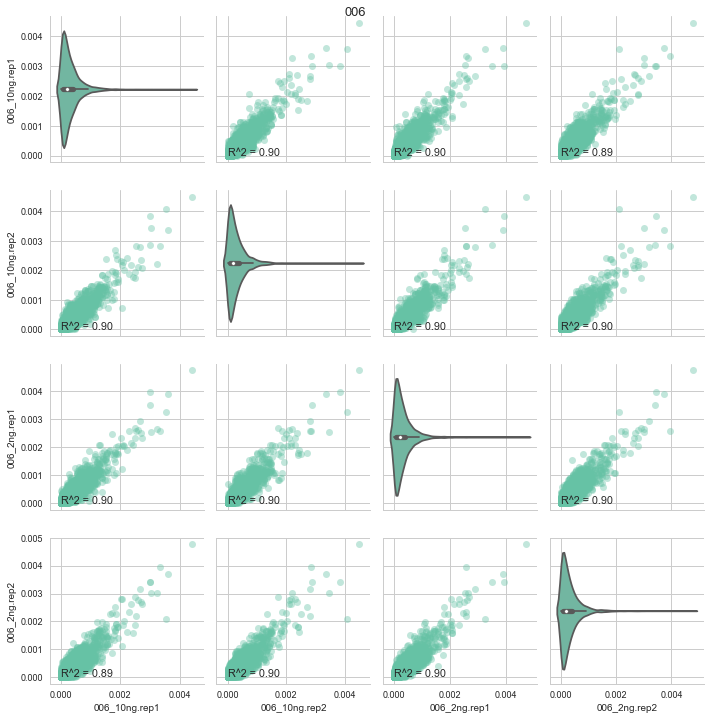

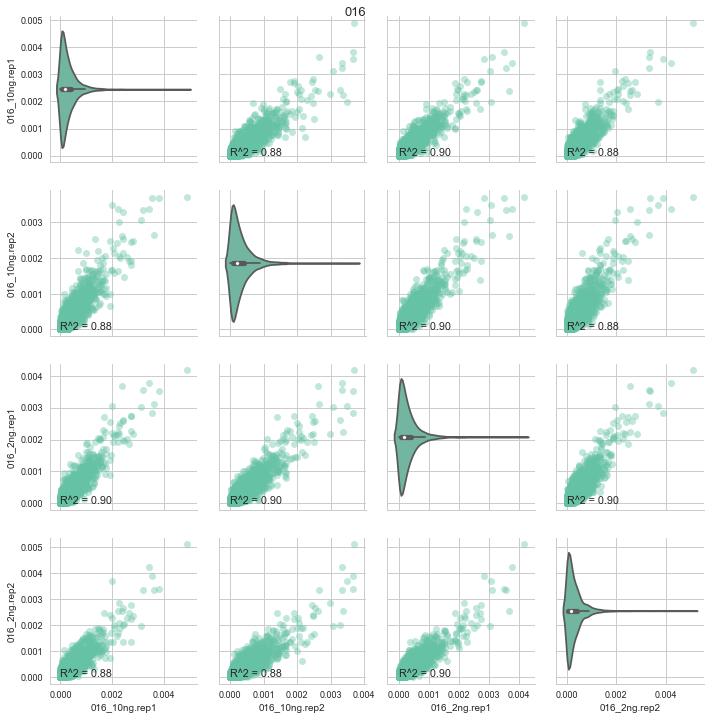

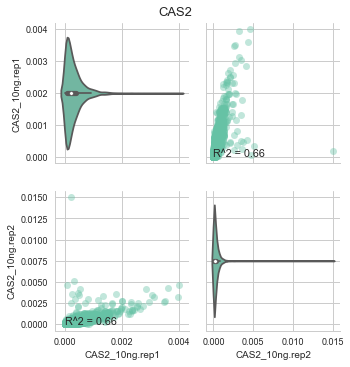

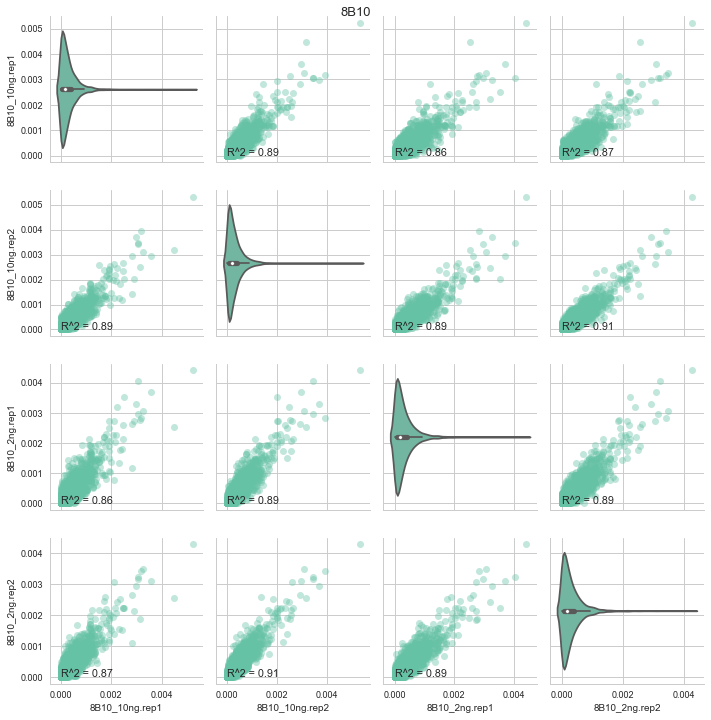

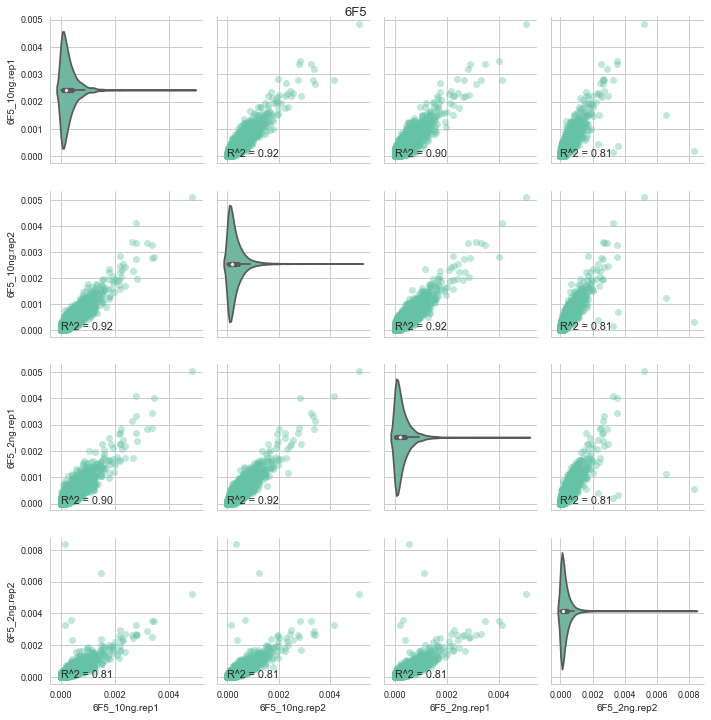

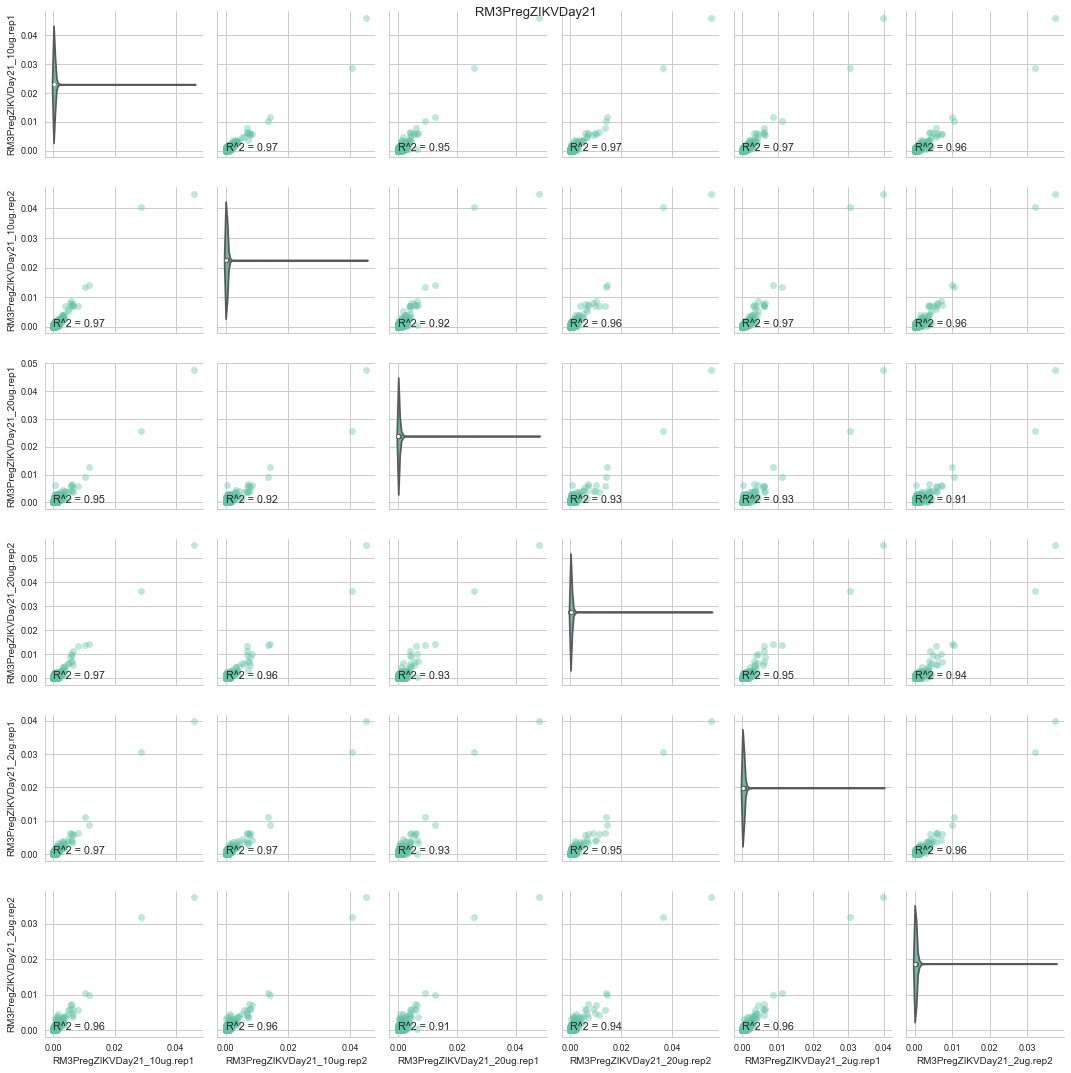

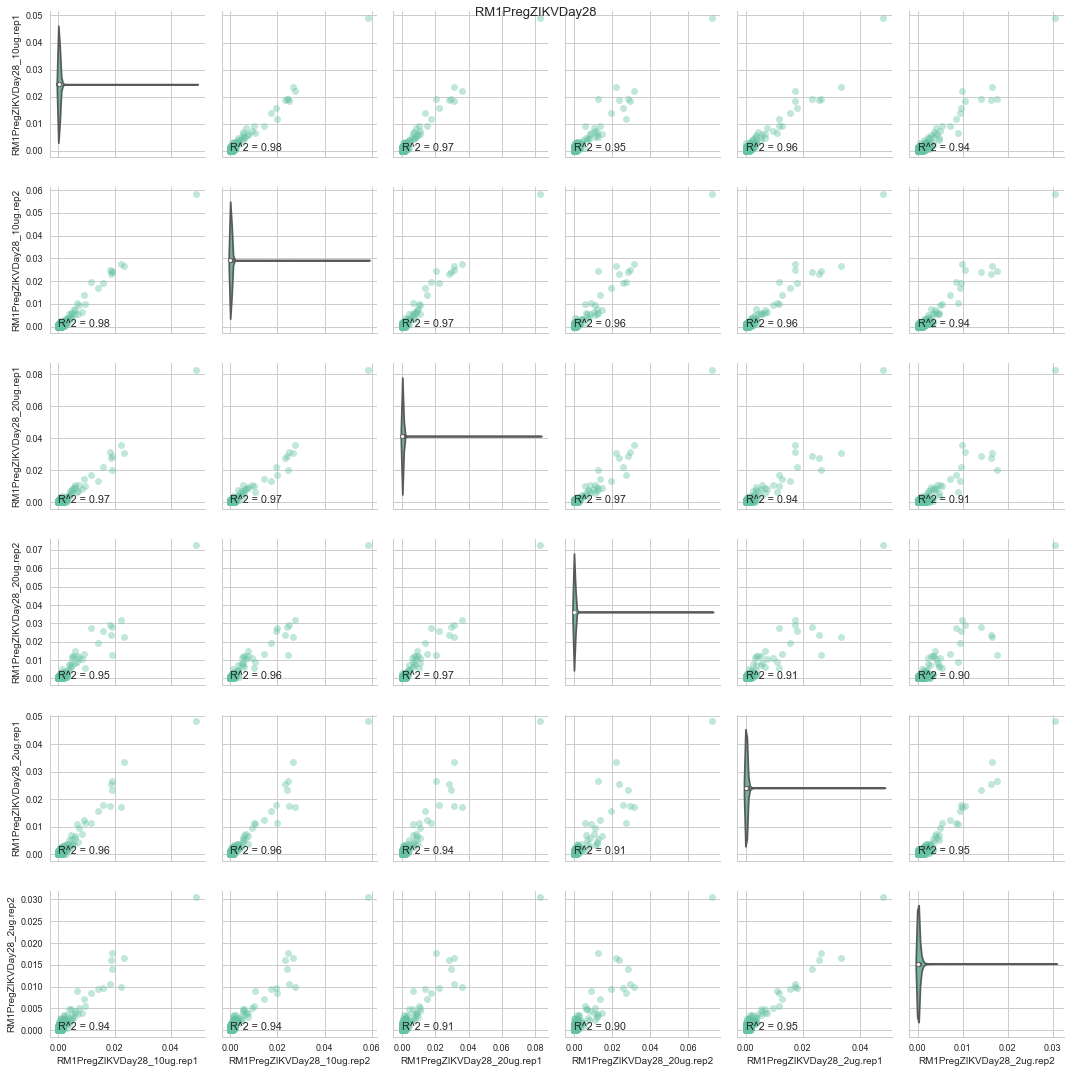

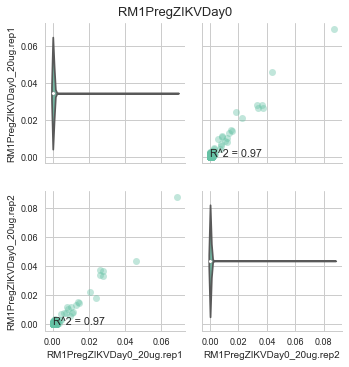

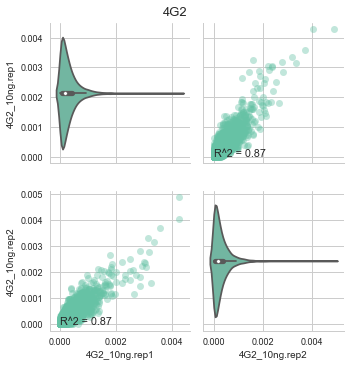

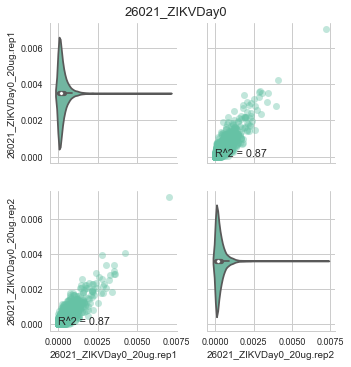

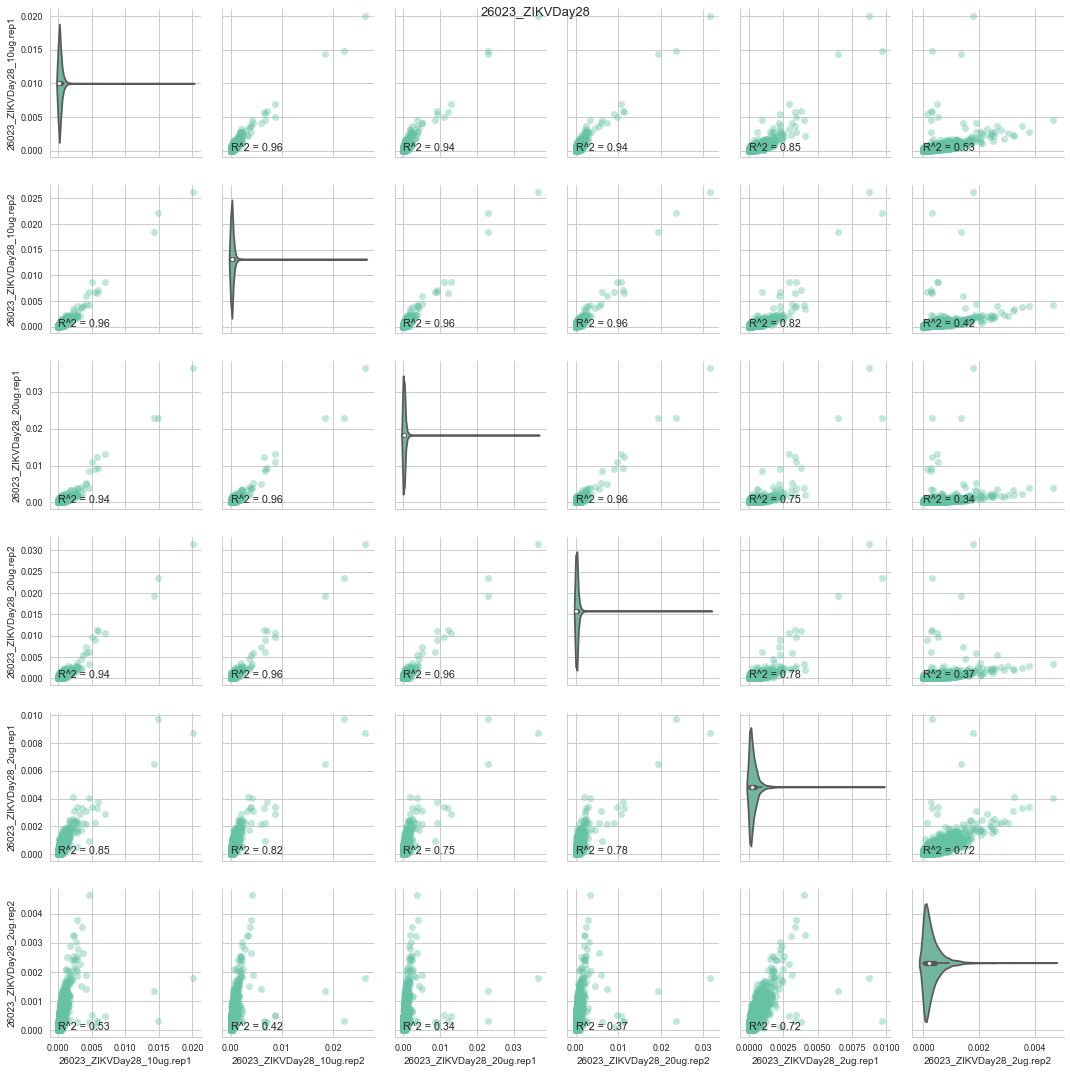

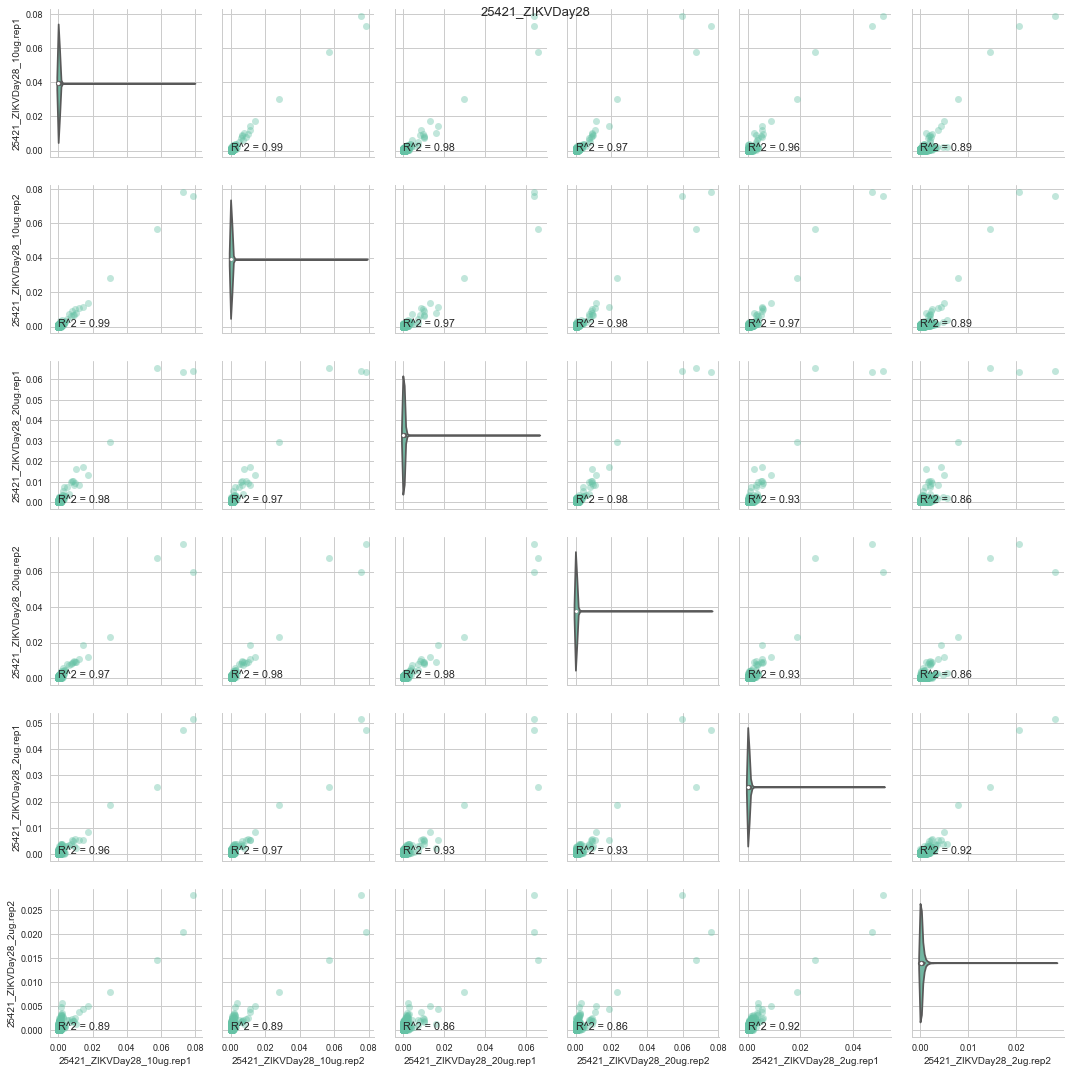

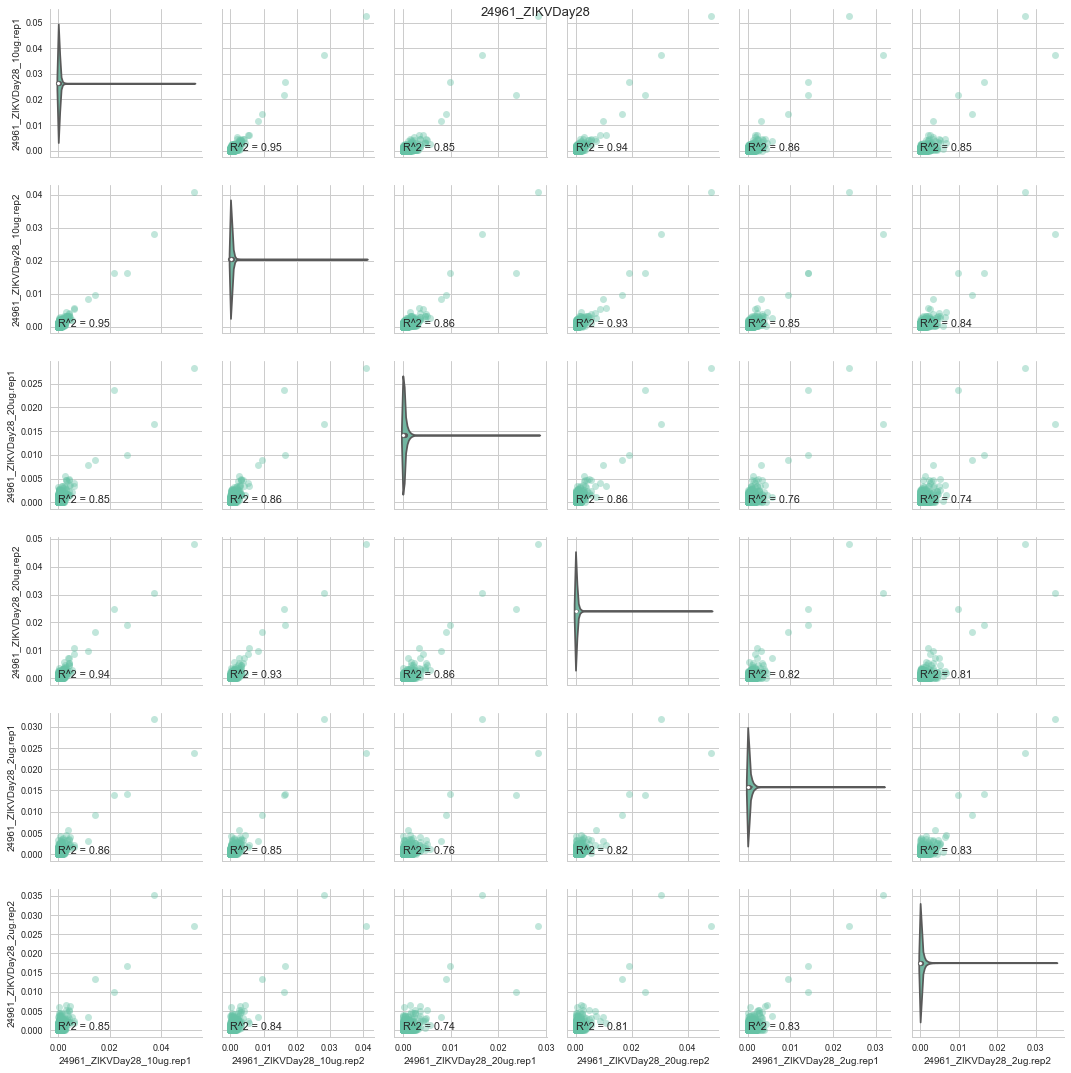

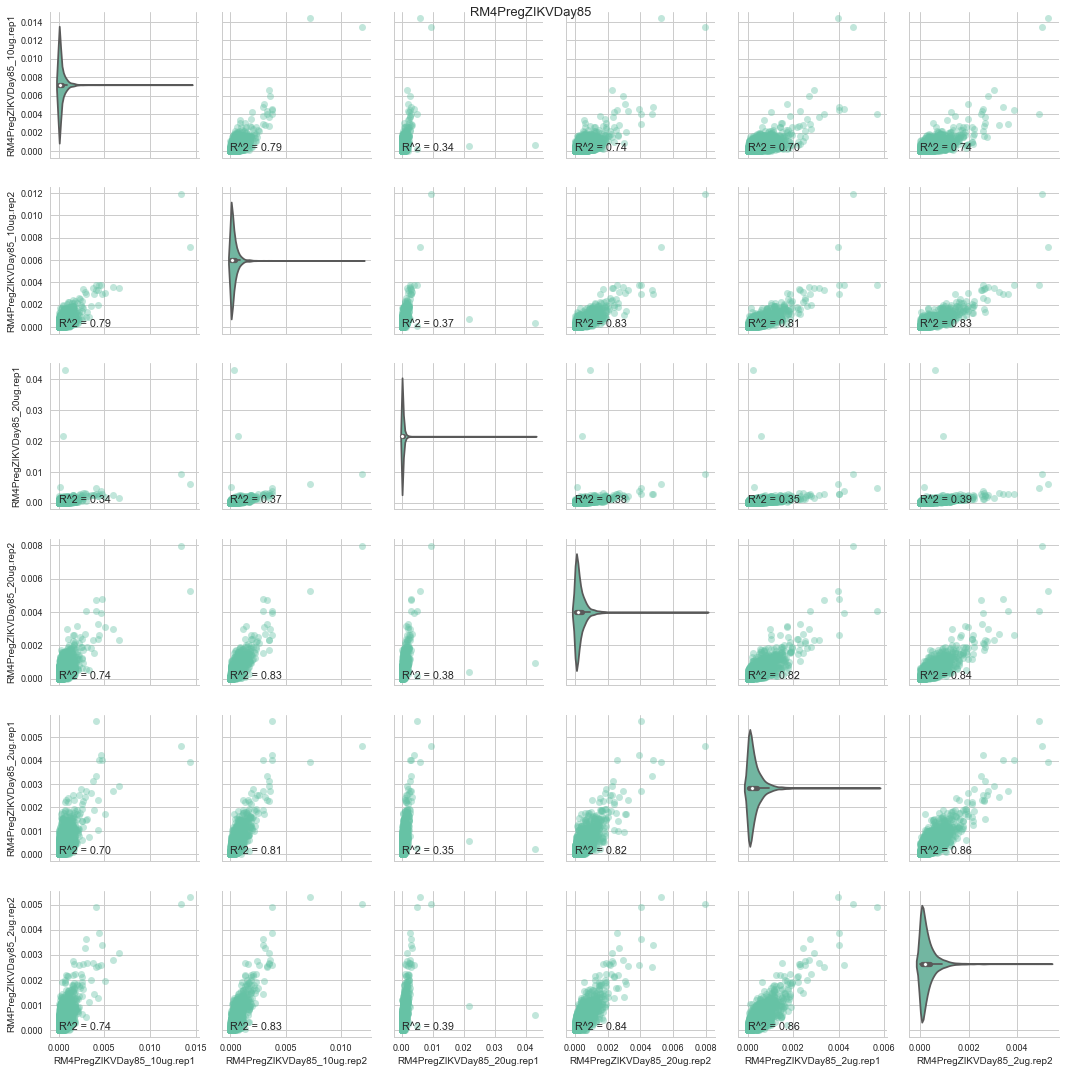

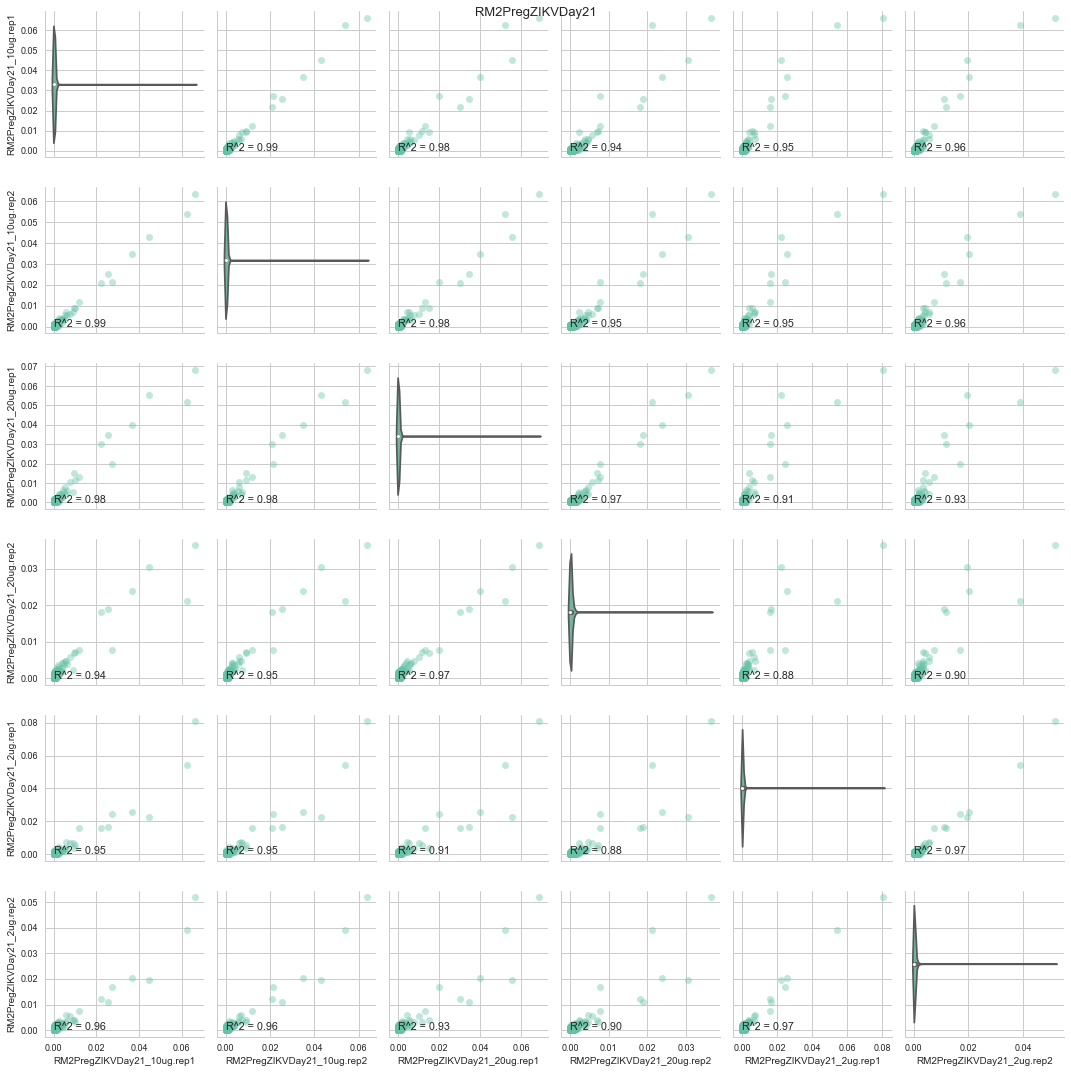

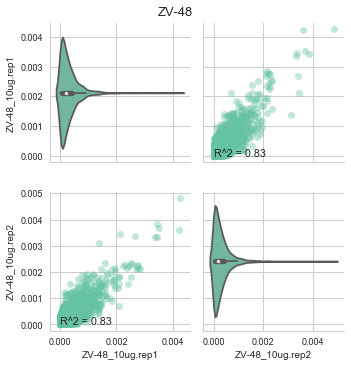

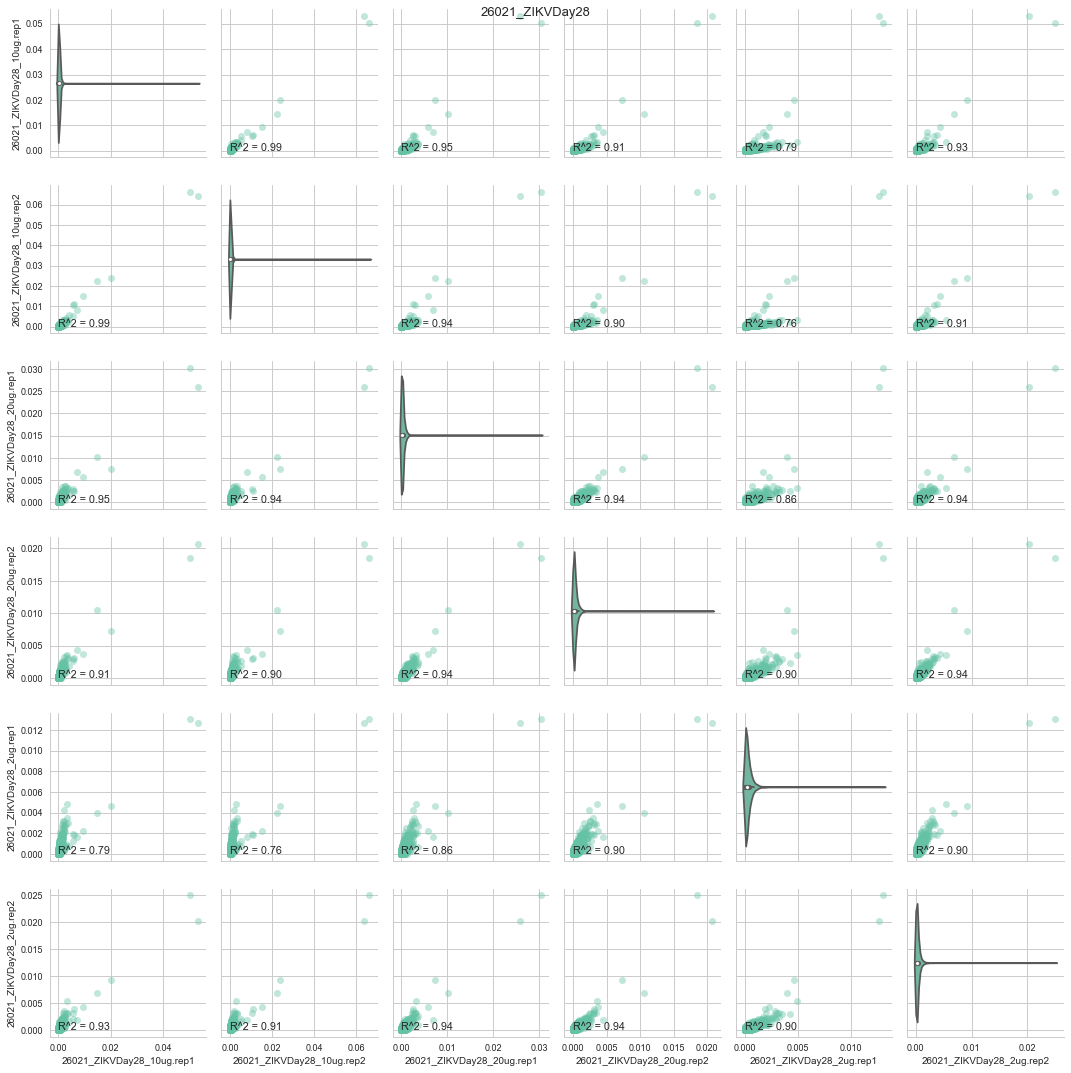

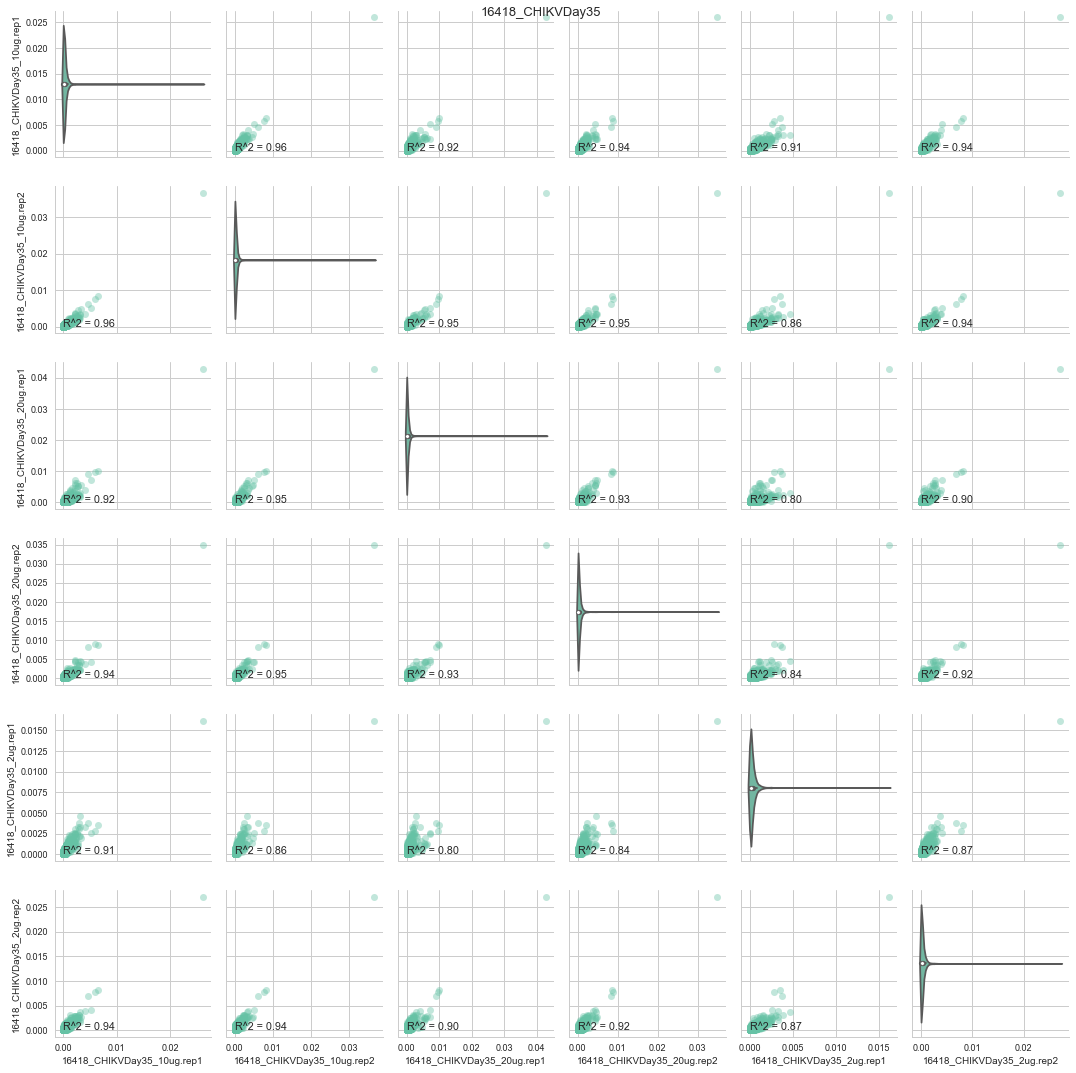

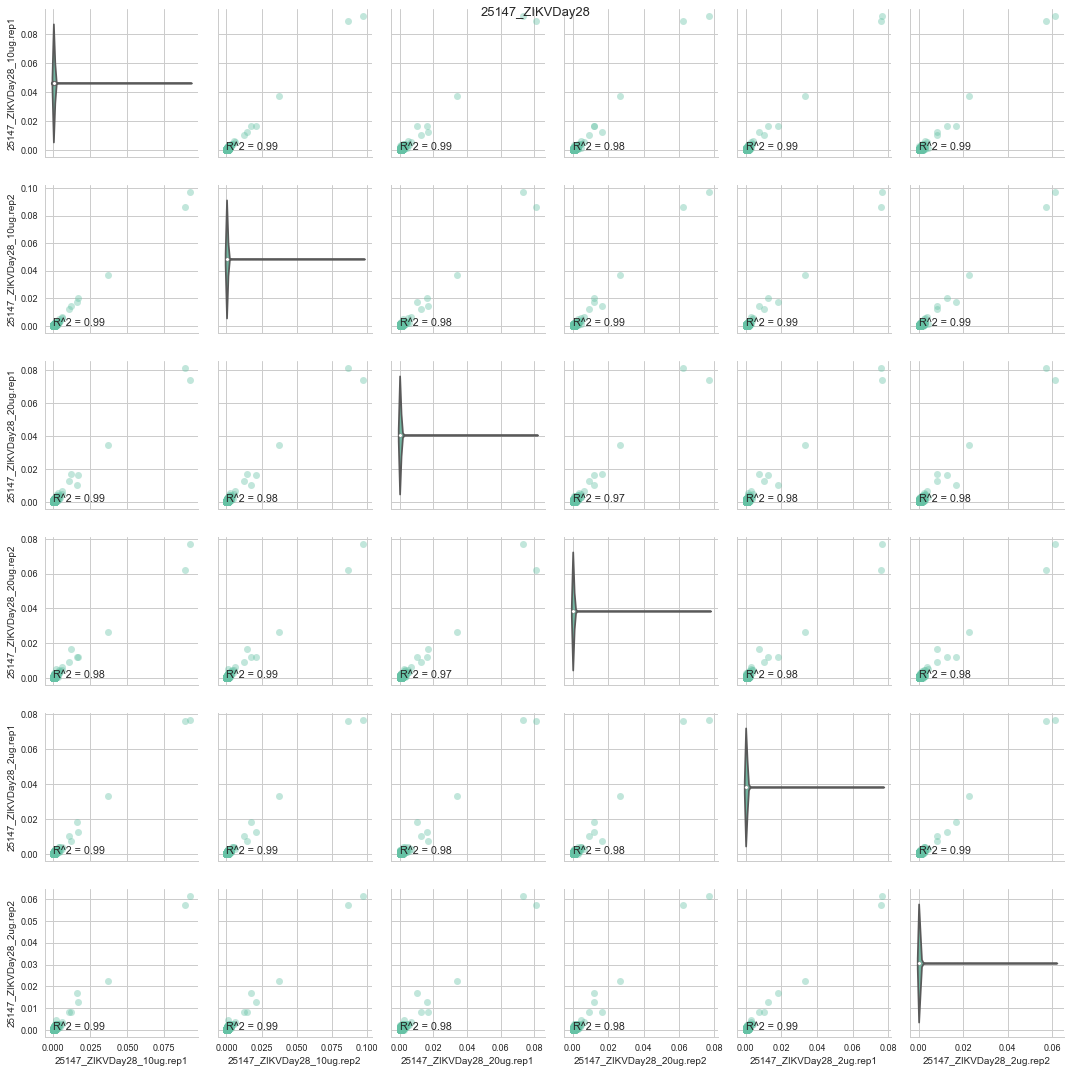

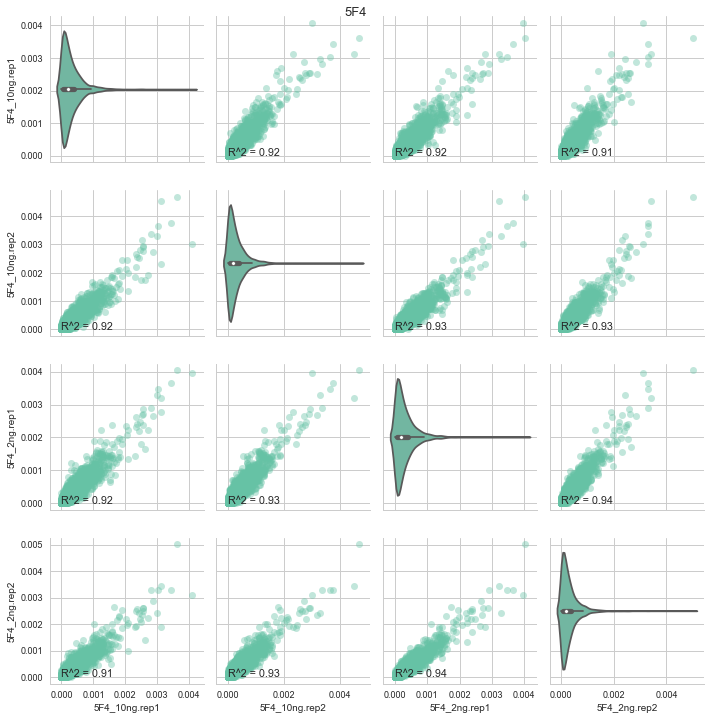

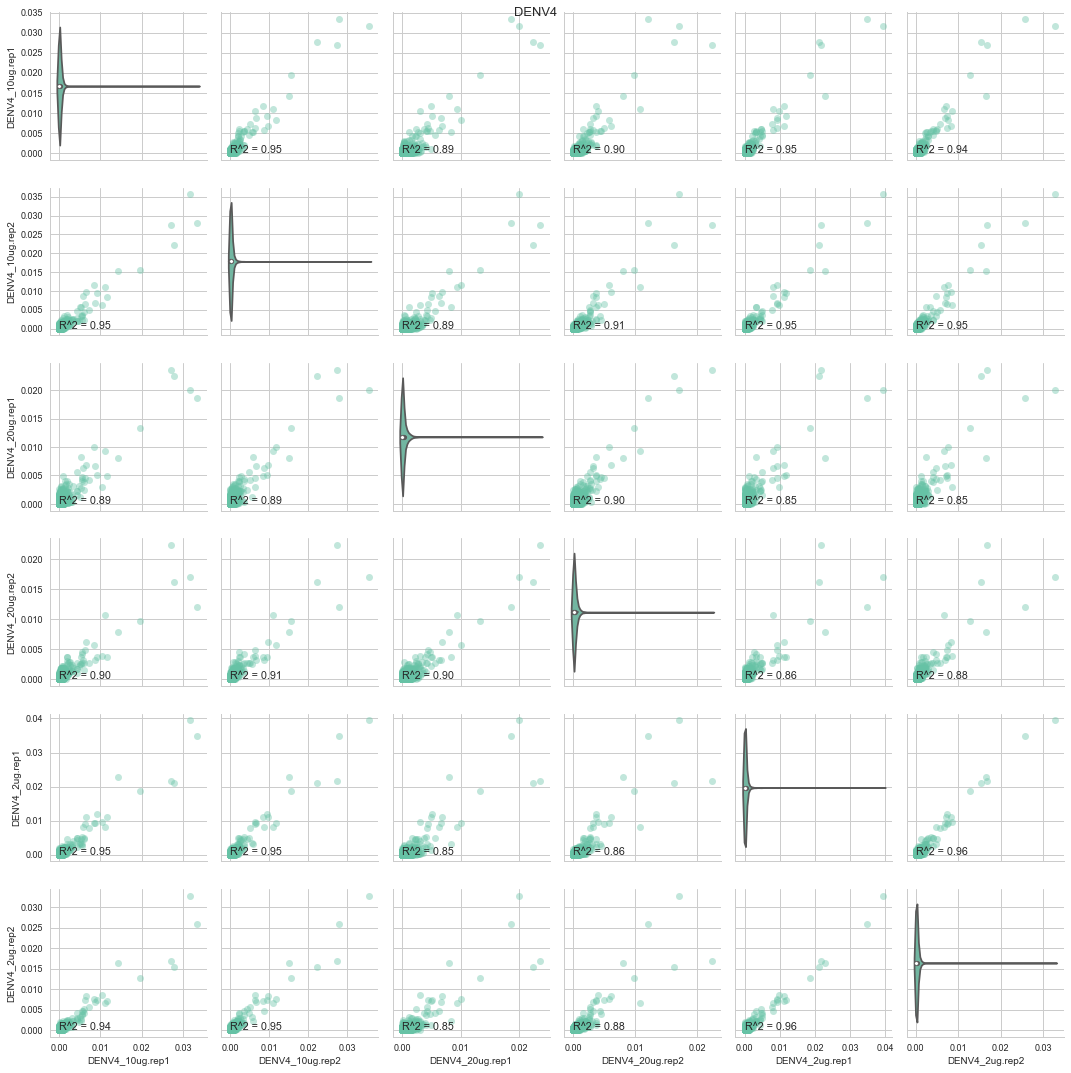

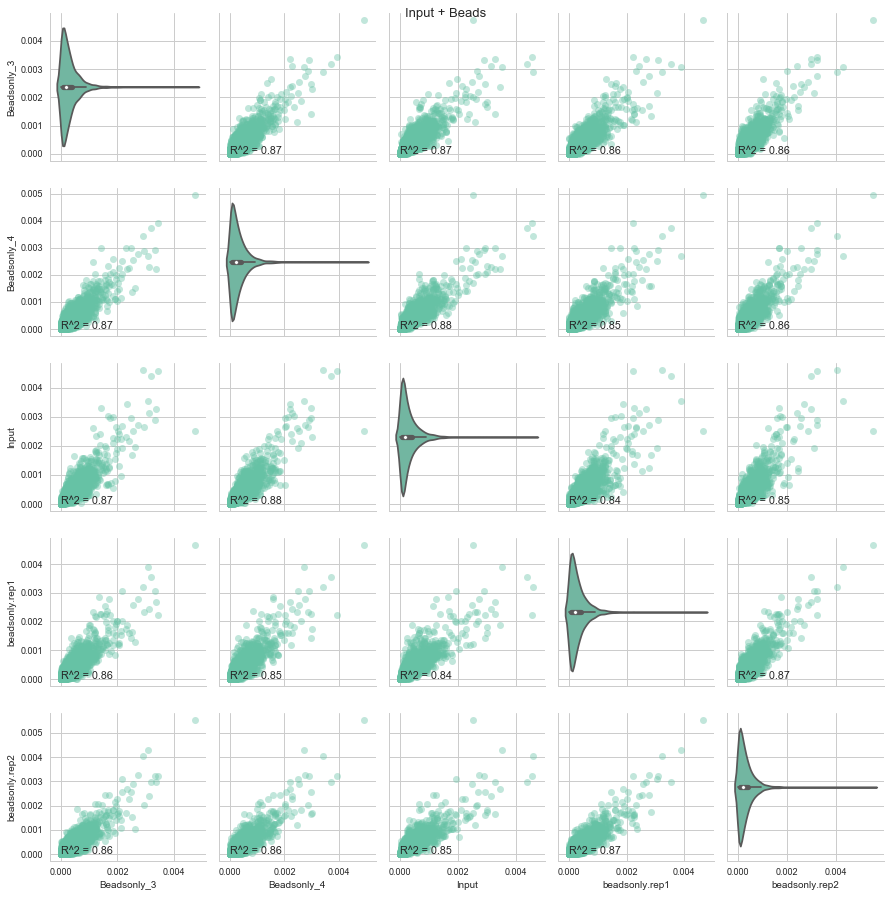

In [15]:
sns.set(style='whitegrid', font_scale = 0.9, palette='Set2') ## Make all of our plots prettier
def compare_replicates(df, columns, title, fname):
    ''' Plot sanity checks for technical replicates '''
    if columns:
        if len(columns) == 1:
            return
        replicates = df[sorted(columns)]
        replicates.fillna(0, inplace=True)
    else:
        replicates = df

    def plot_comparison(x,y, **kwargs):
        scatter = plt.plot(x,y, 'o', alpha=0.4)
        try:
            r_2 = linregress(x,y)[2]
            scatter[0].axes.text(0,0, 'R^2 = %.2f'%(r_2))
        except:
            pass
        return scatter

    g = sns.PairGrid(replicates, diag_sharey=False)
    g.map_diag(sns.violinplot)
    g.map_offdiag(plot_comparison, )

    g.fig.suptitle(title, va='bottom')
    plt.tight_layout()
    plt.show()
#     plt.savefig(out_path+'/figs/'+fname, bbox_inches='tight')
    plt.close()

for serum, tech_reps in technical_replicates.items():
    compare_replicates(values, tech_reps, serum, serum+'_tech_reps.png')

# for serum, bio_reps in biological_replicates.items():
#     compare_replicates(values, bio_reps, serum, serum+'_bio_reps.png')

compare_replicates(values, input_cols + beads_cols, 'Input + Beads', 'ctrl_reps.png')

In [10]:
drop = ['26023_ZIKVDay0_20ug.rep2', '26023_ZIKVDay0_20ug.rep2', 
        'CAS2_10ng.rep1', 
        '26023_ZIKVDay28_2ug.rep1', '26023_ZIKVDay28_2ug.rep2', 
        '25421_ZIKVDay28_2ug.rep2',
       'RM4PregZIKVDay85_20ug.rep1',
       '26021_ZIKVDay28_2ug.rep1']

with open('./drop.tsv', 'w') as f:
    f.write('\n'.join(drop))

In [11]:
#######  Tidy up the metadata a bit  ########
# Tidy start and end coordinates --> integers
metadata['start'], metadata['end'] = metadata['Start_to_End_nt'].str.split('to', 1).str
metadata['start'] = metadata['start'].map(lambda x: int(x))
metadata['end'] = metadata['end'].map(lambda x: int(x.split('.')[0])) ## TODO
metadata.drop('Start_to_End_nt', inplace=True, axis=1)

# Tidy up virus and strain names
def parse_strains(virusstrain):
    # e.g., 'DENV3_BR-BID-V2403-2008.DENV3_Mozambique1985'
    # The ONNV sequences overlap with the CHIKV sequences; for now, we'll omit it; this should be revisited. TODO

    names = [s for s in virusstrain.split('.') if 'ONNV' not in s] # ['DENV3_BR-BID-V2403-2008', 'DENV3_Mozambique1985']
    virus = [s.split('_', 1)[0] for s in names] # ['DENV3']

    if len(set(virus)) != 1:
        virus, strains = np.nan, np.nan

    else:
        virus = virus[0] # 'DENV3'
        strains = [s.split(virus+'_', 1)[1].replace('-', '').replace('_', '').upper() for s in names if s != '']
        # ['BRBIDV24032008', 'MOZAMBIQUE1985']

    return pd.Series({'virus': virus, 'strains':strains})

new_names = [parse_strains(v) for v in metadata['Virus_Strain']]
metadata['virus'] = [n['virus'] for n in new_names]
metadata['strains'] = [n['strains'] for n in new_names]
metadata.rename(columns={'Peptide_sequence':'sequence'}, inplace=True)
metadata.drop('Virus_Strain', axis=1, inplace=True)
metadata.dropna(how='any', inplace=True, axis=(0, 1))

#####   Write to file   #####
values = values.join(metadata, how='inner')


/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [12]:
print values.head()
values.to_csv(out_path+'proportions.csv')

                006_10ng.rep1  006_10ng.rep2  006_2ng.rep1  006_2ng.rep2  \
id                                                                         
1                         139            183           143            95   
100                        15             44            48            34   
1001                       43             38             4            32   
1002                       22             39            44            43   
1008.1177.1346            301            406           354           202   

                016_10ng.rep1  016_10ng.rep2  016_2ng.rep1  016_2ng.rep2  \
id                                                                         
1                          25            110            96            40   
100                         2             25            24             9   
1001                       11             15            12             3   
1002                       16             38             6             8   
1008.1177.1

In [21]:
pprint(technical_replicates)

{'006': ['006_10ng.rep1', '006_10ng.rep2', '006_2ng.rep1', '006_2ng.rep2'],
 '016': ['016_10ng.rep1', '016_10ng.rep2', '016_2ng.rep1', '016_2ng.rep2'],
 '067': ['067_10ng.rep1', '067_10ng.rep2', '067_2ng.rep1', '067_2ng.rep2'],
 '072': ['072_10ng.rep1', '072_10ng.rep2', '072_2ng.rep1', '072_2ng.rep2'],
 '16418_CHIKVDay0': ['16418_CHIKVDay0_20ug.rep1', '16418_CHIKVDay0_20ug.rep2'],
 '16418_CHIKVDay35': ['16418_CHIKVDay35_10ug.rep1',
                      '16418_CHIKVDay35_10ug.rep2',
                      '16418_CHIKVDay35_20ug.rep1',
                      '16418_CHIKVDay35_20ug.rep2',
                      '16418_CHIKVDay35_2ug.rep1',
                      '16418_CHIKVDay35_2ug.rep2'],
 '240D': ['240D_10ng.rep1', '240D_10ng.rep2'],
 '24961_ZIKVDay28': ['24961_ZIKVDay28_10ug.rep1',
                     '24961_ZIKVDay28_10ug.rep2',
                     '24961_ZIKVDay28_20ug.rep1',
                     '24961_ZIKVDay28_20ug.rep2',
                     '24961_ZIKVDay28_2ug.rep1',
         